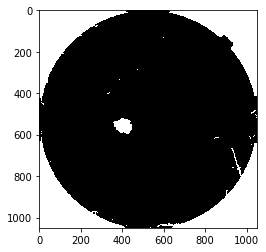

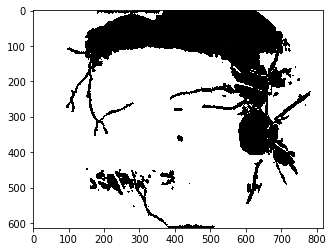

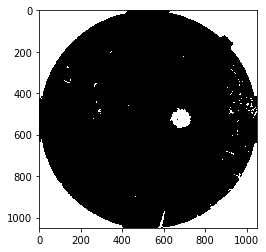

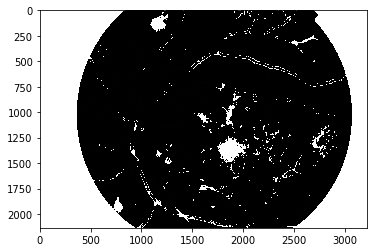

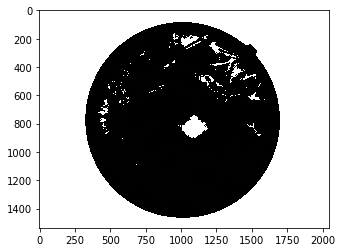

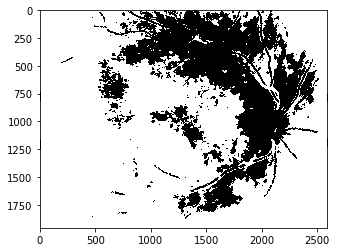

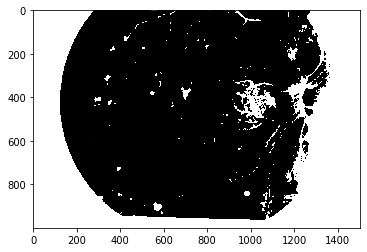

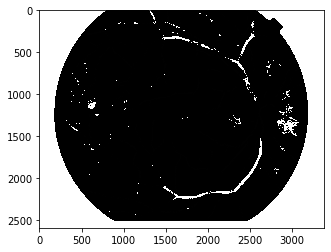

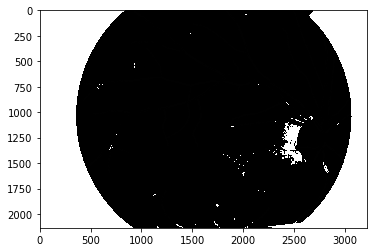

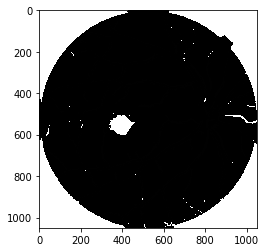

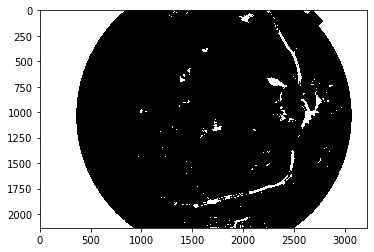

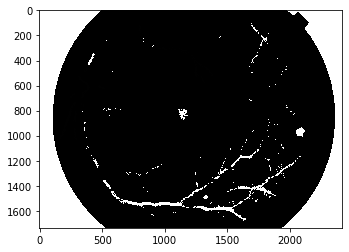

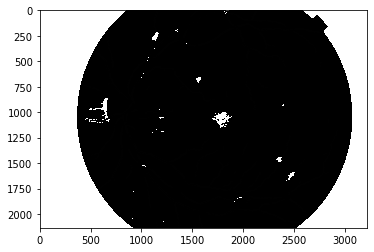

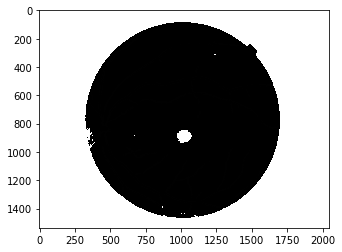

In [5]:
import cv2
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

def Hemorrhage(veins, image):
    #first re-sized to a pre-defined dimension
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    median = cv2.medianBlur(image, 1)
    compare = np.concatenate((image, median), axis=1) #side by side comparison
    #medianPixels = np.array(median)
    #plt.imshow(medianPixels)
    
    #Step 1 - retinal blood vessel detection
    #take green channel
    b, g, r = cv2.split(median)
    green_image = median.copy() # Make a copy
    green_image[:,:,0] = 0
    green_image[:,:,2] = 0
    gPixels = np.array(green_image)
    
    
    #-----Converting image to LAB Color model----------------------------------- 
    lab= cv2.cvtColor(gPixels, cv2.COLOR_BGR2LAB)
    #cv2.imshow("lab",lab)

    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)
    lo = cv2.resize(l, (640, 540)) 
    #cv2.imshow('l_channel', lo)
    ao = cv2.resize(a, (640, 540)) 
    #cv2.imshow('a_channel', ao)
    bo = cv2.resize(b, (640, 540)) 
    #cv2.imshow('b_channel', bo)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    clo = cv2.resize(cl, (640, 540)) 
    #cv2.imshow('CLAHE output', clo)

    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))
    limgo = cv2.resize(limg, (640, 540)) 
    #cv2.imshow('limg', limgo)

    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    finalo = cv2.resize(final, (640, 540)) 
    #cv2.imshow('final', finalo)
    
    
    #Apply Black Top-hat method is used for initial blood vessel enhancement
    blacktophat = cv2.morphologyEx(final, cv2.MORPH_TOPHAT, (1,1))
    
    #Gaussian matched filtering method  is applied for further vessel enhancement
    height, width = blacktophat.shape[0:2]
    rotationMatrix = cv2.getRotationMatrix2D((width/2, height/2), 15, 7)

    blur = cv2.medianBlur(final,7,0)
    
    ret, thresh2 = cv2.threshold(cv2.cvtColor(blur,cv2.COLOR_RGB2GRAY),0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    opening = cv2.morphologyEx(thresh2,cv2.MORPH_OPEN, (10,10))
    
    hammerage = cv2.morphologyEx(opening - veins,cv2.MORPH_ERODE, (10,10))
    
    plt.imshow(hammerage, cmap='gray')
    plt.show()
    

def extract_bv(image):
    b,green_fundus,r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced_green_fundus = clahe.apply(green_fundus)

    # applying alternate sequential filtering (3 times closing opening)
    r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
    f5 = clahe.apply(f4)

    # removing very small contours through area parameter noise removal
    ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)	
    mask = np.ones(f5.shape[:2], dtype="uint8") * 255	
    im2, contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 200:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    im = cv2.bitwise_and(f5, f5, mask=mask)
    ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)
    newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)

    # removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
    #vessels and also in an interval of area
    fundus_eroded = cv2.bitwise_not(newfin)	
    xmask = np.ones(fundus.shape[:2], dtype="uint8") * 255
    x1, xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in xcontours:
        shape = "unidentified"
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)  
        if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
            shape = "circle"
        else:
            shape = "veins"
        if(shape=="circle"):
            cv2.drawContours(xmask, [cnt], -1, 0, -1)

    finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)
    blood_vessels = finimage #cv2.bitwise_not(finimage)
    
    Hemorrhage(finimage, image)
    
    return blood_vessels

if __name__ == "__main__":
    pathFolder = "train_images/"
    filesArray = [x for x in os.listdir(pathFolder) if os.path.isfile(os.path.join(pathFolder,x))]
    destinationFolder = "Bloodvessels result/"
    if not os.path.exists(destinationFolder):
        os.mkdir(destinationFolder)
    for file_name in filesArray:
        file_name_no_extension = os.path.splitext(file_name)[0]
        fundus = cv2.imread(pathFolder+'/'+file_name)
        bloodvessel = extract_bv(fundus)
        cv2.imwrite(destinationFolder+file_name_no_extension+"_bloodvessel.png",bloodvessel)

In [16]:
#Otsu method to find optimal threshold
img = cv2.imread('train_images/dee687c6e88a.png',0)
blur = cv2.GaussianBlur(img,(5,5),0)
# find normalized_histogram, and its cumulative distribution function
hist = cv2.calcHist([blur],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.max()
Q = hist_norm.cumsum()
bins = np.arange(256)
fn_min = np.inf
thresh = -1
for i in range(1,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
    q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
    b1,b2 = np.hsplit(bins,[i]) # weights
    # finding means and variances
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i
# find otsu's threshold value with OpenCV function
ret, otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
otsuResized = cv2.resize(otsu, (640, 540)) 
cv2.imshow('final', otsuResized)

cv2.waitKey()
cv2.destroyAllWindows()

C:\Users\rsrah\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
C:\Users\rsrah\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
C:\Users\rsrah\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


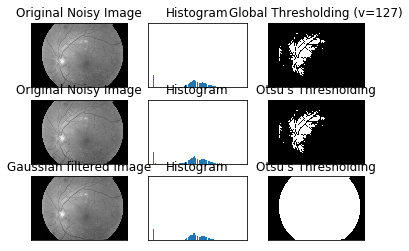

In [30]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread('train_images/dee687c6e88a.png',0)
# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])

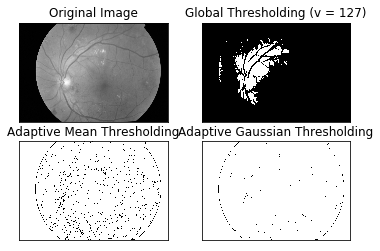

In [27]:
# Adaptive Thresholding
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread('train_images/dee687c6e88a.png',0)
img = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()